In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0 # Using a smaller EfficientNet variant
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import cv2 
import glob

In [ ]:
# --- Configuration & Constants ---
BASE_DATASET_PATH = './k_CBIS-DDSM/'
METADATA_CSV_PATH = os.path.join(BASE_DATASET_PATH, 'calc_case(with_jpg_img).csv')

IMAGE_ROOT_DIR = BASE_DATASET_PATH
ACTUAL_IMAGE_FILES_BASE_DIR = os.path.join(IMAGE_ROOT_DIR, 'jpg_img')

# Column in CSV that conceptually should point to ROIs, even if paths are flawed
CONCEPTUAL_ROI_COLUMN_NAME = 'jpg_ROI_img_path'
PATHOLOGY_COLUMN_NAME = 'pathology'

# Model & Training Parameters
IMG_WIDTH, IMG_HEIGHT = 224, 224 # EfficientNetB0 default input size
BATCH_SIZE = 32
EPOCHS = 50 # Initial epochs for head training
FINE_TUNE_EPOCHS = 20 # Additional epochs for fine-tuning
LEARNING_RATE = 1e-4
RANDOM_STATE = 42
# --- End of Configuration & Constants ---

In [ ]:
# --- Phase 1: Data Loading and Preprocessing with HEURISTIC PATH FINDING ---

print("--- Initial Path Configuration Debug ---")
print(f"Current working directory (CWD): {os.getcwd()}")
print(f"BASE_DATASET_PATH (relative from CWD as defined): {BASE_DATASET_PATH}")
print(f"METADATA_CSV_PATH (relative from CWD as defined): {METADATA_CSV_PATH}")
print(f"IMAGE_ROOT_DIR (relative from CWD as defined): {IMAGE_ROOT_DIR}")
print(f"ACTUAL_IMAGE_FILES_BASE_DIR (relative from CWD as defined): {ACTUAL_IMAGE_FILES_BASE_DIR}")

# Resolve to absolute paths for clarity and checking
abs_base_dataset_path = os.path.abspath(BASE_DATASET_PATH)
abs_metadata_csv_path = os.path.abspath(METADATA_CSV_PATH)
abs_image_root_dir = os.path.abspath(IMAGE_ROOT_DIR)
abs_actual_image_files_base_dir = os.path.abspath(ACTUAL_IMAGE_FILES_BASE_DIR)

print(f"\nResolved BASE_DATASET_PATH to absolute: {abs_base_dataset_path}")
print(f"  -> Exists? {os.path.exists(abs_base_dataset_path)} | Is Dir? {os.path.isdir(abs_base_dataset_path)}")

print(f"Resolved METADATA_CSV_PATH to absolute: {abs_metadata_csv_path}")
print(f"  -> Exists? {os.path.exists(abs_metadata_csv_path)} | Is File? {os.path.isfile(abs_metadata_csv_path)}")

print(f"Resolved IMAGE_ROOT_DIR to absolute: {abs_image_root_dir}")
print(f"  -> Exists? {os.path.exists(abs_image_root_dir)} | Is Dir? {os.path.isdir(abs_image_root_dir)}")

print(f"Resolved ACTUAL_IMAGE_FILES_BASE_DIR (where series folders should be): {abs_actual_image_files_base_dir}")
print(f"  -> Exists? {os.path.exists(abs_actual_image_files_base_dir)} | Is Dir? {os.path.isdir(abs_actual_image_files_base_dir)}")

if os.path.exists(abs_actual_image_files_base_dir) and os.path.isdir(abs_actual_image_files_base_dir):
    print(f"\nSample contents of ACTUAL_IMAGE_FILES_BASE_DIR ('{abs_actual_image_files_base_dir}') (first 10 items):")
    try:
        sample_contents = os.listdir(abs_actual_image_files_base_dir)[:10]
        if not sample_contents:
            print("    -> Directory is empty or unreadable.")
        for item_idx, item in enumerate(sample_contents):
            item_abs_path = os.path.join(abs_actual_image_files_base_dir, item)
            item_type = "Dir" if os.path.isdir(item_abs_path) else "File" if os.path.isfile(item_abs_path) else "Other"
            print(f"    -> [{item_type}] {item}")
    except Exception as e:
        print(f"    -> Could not list directory contents: {e}")
else:
    print("\nCRITICAL WARNING: ACTUAL_IMAGE_FILES_BASE_DIR does not exist or is not a directory. Path searches will fail.")
print("--- End of Initial Path Configuration Debug ---\n")


print("Proceeding with CSV loading...")
try:
    source_df = pd.read_csv(METADATA_CSV_PATH)
    print(f"Successfully loaded {METADATA_CSV_PATH}")
    print(f"Columns available: {source_df.columns.tolist()}")
except FileNotFoundError:
    print(f"ERROR: CSV file not found at {METADATA_CSV_PATH}.")
    print("Verify METADATA_CSV_PATH definition and file existence based on the debug info above.")
    raise
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    raise

# Clean and filter initial dataframe
if CONCEPTUAL_ROI_COLUMN_NAME not in source_df.columns or PATHOLOGY_COLUMN_NAME not in source_df.columns:
    print(f"ERROR: Required columns for metadata ('{CONCEPTUAL_ROI_COLUMN_NAME}' or '{PATHOLOGY_COLUMN_NAME}') not in CSV.")
    print(f"Available columns are: {source_df.columns.tolist()}")
    raise KeyError("Missing essential columns in CSV.")

source_df.dropna(subset=[CONCEPTUAL_ROI_COLUMN_NAME, PATHOLOGY_COLUMN_NAME], inplace=True)
source_df = source_df[source_df[PATHOLOGY_COLUMN_NAME].isin(['MALIGNANT', 'BENIGN'])]
print(f"Rows after initial cleaning (dropna on conceptual ROI/pathology, pathology filter): {len(source_df)}")

if source_df.empty:
    raise ValueError("DataFrame is empty after initial cleaning. Cannot proceed.")

def heuristic_find_image_path(row, actual_images_root_dir_abs):
    try:
        patient_id = row['patient_id']
        breast_side = row['left or right breast']
        image_view = row['image view']
        abnormality_id = str(row['abnormality id']) # Ensure it's a string for concatenation

        csv_conceptual_roi_path = str(row.get(CONCEPTUAL_ROI_COLUMN_NAME, "")).strip()
        
        case_type_folder_prefix = ""
        if csv_conceptual_roi_path.startswith("jpg_img/"):
            path_part = csv_conceptual_roi_path.split('/')[1] # e.g., "Calc_Training_P_00005_..."
            # Extract the part before patient_id
            if path_part.startswith("Calc_Training_"): case_type_folder_prefix = "Calc_Training"
            elif path_part.startswith("Calc_Test_"): case_type_folder_prefix = "Calc_Test"
            elif path_part.startswith("Mass_Training_"): case_type_folder_prefix = "Mass_Training"
            elif path_part.startswith("Mass_Test_"): case_type_folder_prefix = "Mass_Test"
        
        if not case_type_folder_prefix:
            # print(f"DEBUG (heuristic): Could not determine case_type_folder_prefix for {patient_id} from '{csv_conceptual_roi_path}'")
            return None

        # Form search pattern for directories: e.g., /path/to/jpg_img/Calc_Training_P_00005_RIGHT_CC_1-*
        dir_search_prefix = f"{case_type_folder_prefix}_{patient_id}_{breast_side}_{image_view}_{abnormality_id}"
        full_dir_search_pattern = os.path.join(actual_images_root_dir_abs, f"{dir_search_prefix}-*")
        
        potential_series_dirs = glob.glob(full_dir_search_pattern)
        
        if not potential_series_dirs:
            # print(f"DEBUG (heuristic): No series directory found for {patient_id} with pattern '{full_dir_search_pattern}'")
            return None

        roi_filename_patterns = [
            "ROI-mask-images-img_0-*.jpg", "ROI-mask-images-img_1-*.jpg", "ROI-mask-images-img_*-*.jpg"
        ]
        
        for series_dir_on_disk in sorted(potential_series_dirs):
            if os.path.isdir(series_dir_on_disk):
                for pattern in roi_filename_patterns:
                    image_search_glob = os.path.join(series_dir_on_disk, pattern)
                    found_roi_files = glob.glob(image_search_glob)
                    if found_roi_files:
                        found_roi_files.sort()
                        return found_roi_files[0] # Return the first valid ROI found
        return None
    except Exception as e:
        # print(f"DEBUG (heuristic): Error for row {row.get('patient_id', 'Unknown')}: {e}")
        return None

print("Attempting HEURISTIC search for valid ROI paths for each CSV entry...")
source_df['full_image_path'] = source_df.apply(
    lambda r: heuristic_find_image_path(r, abs_actual_image_files_base_dir), axis=1
)

metadata_df = source_df.dropna(subset=['full_image_path']).copy()
found_image_count = len(metadata_df)
print(f"Found {found_image_count} actual image files (ROIs if available) after HEURISTIC search.")

if found_image_count == 0:
    print("CRITICAL ERROR: Still no valid image files found even after heuristic search.")
    raise FileNotFoundError("No usable image files found even with heuristic search.")

metadata_df.rename(columns={'full_image_path': 'full_roi_path'}, inplace=True)

label_encoder = LabelEncoder()
metadata_df.loc[:, 'pathology_encoded'] = label_encoder.fit_transform(metadata_df[PATHOLOGY_COLUMN_NAME])
target_names = list(label_encoder.classes_)

X = metadata_df['full_roi_path']
y = metadata_df['pathology_encoded']
print(f"Number of samples going into train_test_split: {len(X)}")

if len(X) == 0:
     raise ValueError("Dataset is empty, cannot split.")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train_val
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

def load_and_preprocess_image(image_path_tensor, label_tensor):
    # This function is wrapped by tf.py_function, so inputs are tensors.
    # Convert image_path_tensor to a Python string for cv2.imread
    image_path_str = image_path_tensor.numpy().decode('utf-8')
    
    try:
        img = cv2.imread(image_path_str)
        if img is None: # Check if image loading failed
            # print(f"Warning: Could not read image {image_path_str}. Returning dummy data.")
            # Return dummy data that matches expected types and shapes
            dummy_img_array = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
            # Preprocess even the dummy image if your model expects preprocessed input
            dummy_img_processed = tf.keras.applications.efficientnet.preprocess_input(dummy_img_array.copy())
            error_label = np.int32(-1) # Special label to indicate a problem
            return dummy_img_processed, error_label
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV loads as BGR, convert to RGB
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        # Ensure img is float32 before preprocessing if preprocess_input expects that
        img_float32 = img.astype(np.float32)
        img_processed = tf.keras.applications.efficientnet.preprocess_input(img_float32)
        
        # Ensure label is also returned as the correct type (np.int32 for the tf.py_function Tout)
        return img_processed, label_tensor.numpy().astype(np.int32) # Ensure label is also concrete numpy value for return

    except Exception as e:
        # print(f"Error processing image {image_path_str}: {e}. Returning dummy data.")
        # Return dummy data in case of any other exception during processing
        dummy_img_array = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        dummy_img_processed = tf.keras.applications.efficientnet.preprocess_input(dummy_img_array.copy())
        error_label = np.int32(-1) # Special label
        return dummy_img_processed, error_label


# Data Augmentation (tf.data has better performance)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1)
])

def create_tf_dataset(image_paths, labels, batch_size, augment=False):
    image_paths_list = list(image_paths) # Ensure it's a list of Python strings
    labels_list = list(labels)       # Ensure it's a list of Python ints/floats

    dataset = tf.data.Dataset.from_tensor_slices((image_paths_list, labels_list))
    
    # Map image loading and preprocessing
    # Tensorflow expects the wrapped function to return types matching `Tout`
    dataset = dataset.map(lambda x, y: tf.py_function(
        load_and_preprocess_image, 
        [x, y], # Inputs to the Python function
        [tf.float32, tf.int32]), # Output types
        num_parallel_calls=tf.data.AUTOTUNE)
    
    # Filter out entries marked with the error_label (-1)
    dataset = dataset.filter(lambda img_tensor, label_tensor: label_tensor != -1)
    
    # All images passing the filter should now have the correct shape.
    def set_shape(img, label):
        img.set_shape((IMG_WIDTH, IMG_HEIGHT, 3))
        label.set_shape(()) # Label is a scalar
        return img, label
    dataset = dataset.map(set_shape, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Recreate datasets with the modified functions
print("Recreating TensorFlow datasets with updated image loading logic...")
train_dataset = create_tf_dataset(X_train, y_train, BATCH_SIZE, augment=True)
val_dataset = create_tf_dataset(X_val, y_val, BATCH_SIZE, augment=False)
test_dataset = create_tf_dataset(X_test, y_test, BATCH_SIZE, augment=False)

# Verify a batch shape and count items (good here since the dataset is not too big! (diferent from the other CBIS-DDSM works))
print("Verifying dataset integrity (this might take a moment)...")
train_count = 0
for _ in train_dataset:
    train_count += 1
print(f"Number of batches in train_dataset: {train_count}")
if train_count > 0:
    for images, labels in train_dataset.take(1):
        print("Sample batch shape from train_dataset:", images.shape, labels.shape)
else:
    print("Warning: train_dataset is empty after filtering. Check for widespread image loading issues.")

val_count = 0
for _ in val_dataset:
    val_count +=1
print(f"Number of batches in val_dataset: {val_count}")

test_count = 0
for _ in test_dataset:
    test_count += 1
print(f"Number of batches in test_dataset: {test_count}")

--- Initial Path Configuration Debug ---
Current working directory (CWD): /home/renato/Programming/CBIS-DDSM
BASE_DATASET_PATH (relative from CWD as defined): ./k_CBIS-DDSM/
METADATA_CSV_PATH (relative from CWD as defined): ./k_CBIS-DDSM/calc_case(with_jpg_img).csv
IMAGE_ROOT_DIR (relative from CWD as defined): ./k_CBIS-DDSM/
ACTUAL_IMAGE_FILES_BASE_DIR (relative from CWD as defined): ./k_CBIS-DDSM/jpg_img

Resolved BASE_DATASET_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM
  -> Exists? True | Is Dir? True
Resolved METADATA_CSV_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM/calc_case(with_jpg_img).csv
  -> Exists? True | Is File? True
Resolved IMAGE_ROOT_DIR to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM
  -> Exists? True | Is Dir? True
Resolved ACTUAL_IMAGE_FILES_BASE_DIR (where series folders should be): /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM/jpg_img
  -> Exists? True | Is Dir? True

Sample contents of ACTUAL_IMAGE_FILES_BASE_

2025-05-17 17:34:27.522463: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# --- 2. Model Architecture ---
print("\nPhase 2: Building the Model")
base_model = EfficientNetB0(include_top=False, weights='imagenet',
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model.trainable = False # Start with base model frozen

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(0.3, name="top_dropout_1")(x)
x = Dense(128, activation='relu', name="dense_128")(x)
x = Dropout(0.3, name="top_dropout_2")(x)
outputs = Dense(1, activation='sigmoid', name="predictions")(x)
model = Model(inputs, outputs)


Phase 2: Building the Model


In [8]:
# --- 3. Model Compilation ---
print("\nPhase 3: Compiling the Model")
optimizer = Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()


Phase 3: Compiling the Model


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# --- 4. Training the Model (Head Only) ---
print("\nPhase 4: Training the Model (Head Only)")
checkpoint_filepath_head = './best_model_head_only.keras'
callbacks_head = [
    ModelCheckpoint(filepath=checkpoint_filepath_head, save_weights_only=False, monitor='val_auc', mode='max', save_best_only=True),
    EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, mode='min')
]
history_head = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks_head
)

print("Loading best weights from head training...")
model.load_weights(checkpoint_filepath_head) # Load best weights saved

# --- 4b. Fine-tuning Phase ---
print("\nPhase 4b: Fine-tuning (Unfreezing some base model layers)")
base_model.trainable = True
# for layer in base_model.layers[-30:]: # Example: unfreeze last 30 layers
#    if not isinstance(layer, tf.keras.layers.BatchNormalization):
#        layer.trainable = True
# Keep Batch Normalization layers frozen
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

optimizer_fine_tune = Adam(learning_rate=LEARNING_RATE / 10) # Use a smaller LR
model.compile(optimizer=optimizer_fine_tune, loss=loss, metrics=metrics) # Re-compile
model.summary()

checkpoint_filepath_finetune = './best_model_finetuned.keras'
callbacks_finetune = [
    ModelCheckpoint(filepath=checkpoint_filepath_finetune, save_weights_only=False, monitor='val_auc', mode='max', save_best_only=True),
    EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True), # Can adjust patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8, mode='min')
]

total_epochs_for_finetuning = EPOCHS + FINE_TUNE_EPOCHS # If you want to run for FINE_TUNE_EPOCHS more

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs_for_finetuning,
    initial_epoch=history_head.epoch[-1] + 1, # Continue from where head training left off
    validation_data=val_dataset,
    callbacks=callbacks_finetune
)

print("Loading best weights from fine-tuning...")
model.load_weights(checkpoint_filepath_finetune) # Load best weights saved from fine-tuning


Phase 4: Training the Model (Head Only)
Epoch 1/50
     29/Unknown 15s 67ms/step - accuracy: 0.4613 - auc: 0.4445 - loss: 0.7551 - precision: 0.4755 - recall: 0.5945

/home/renato/Programming/CBIS-DDSM/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-17 17:34:46.415969: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 204 bytes spill stores, 204 bytes spill loads

2025-05-17 17:34:46.525472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092_0', 464 bytes spill stores, 1372 bytes spill loads

2025-05-17 17:34:46.856882: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are 

30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.4636 - auc: 0.4476 - loss: 0.7533 - precision: 0.4771 - recall: 0.5871 - val_accuracy: 0.4412 - val_auc: 0.4746 - val_loss: 0.6984 - val_precision: 0.4471 - val_recall: 0.4419 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5657 - auc: 0.5949 - loss: 0.6787 - precision: 0.5686 - recall: 0.5505

2025-05-17 17:34:58.850967: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5648 - auc: 0.5939 - loss: 0.6792 - precision: 0.5678 - recall: 0.5498 - val_accuracy: 0.4882 - val_auc: 0.5260 - val_loss: 0.6914 - val_precision: 0.4952 - val_recall: 0.6047 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5537 - auc: 0.5627 - loss: 0.6928 - precision: 0.5573 - recall: 0.5551 - val_accuracy: 0.5176 - val_auc: 0.5490 - val_loss: 0.6873 - val_precision: 0.5208 - val_recall: 0.5814 - learning_rate: 1.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5632 - auc: 0.5984 - loss: 0.6785 - precision: 0.5673 - recall: 0.5519 - val_accuracy: 0.5176 - val_auc: 0.5654 - val_loss: 0.6833 - val_precision: 0.5204 - val_recall: 0.5930 - learning_rate: 1.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5777 - auc: 0.6047 - loss: 0.6769 - precision: 0.5788 - recall: 0.5861 - val_accuracy: 0.5353 - val_auc: 0.5724 - val_loss: 0.6798 - val_pr

2025-05-17 17:35:10.960816: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6154 - auc: 0.6417 - loss: 0.6600 - precision: 0.6296 - recall: 0.5630 - val_accuracy: 0.5471 - val_auc: 0.5790 - val_loss: 0.6780 - val_precision: 0.5517 - val_recall: 0.5581 - learning_rate: 1.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6214 - auc: 0.6735 - loss: 0.6475 - precision: 0.6208 - recall: 0.6342 - val_accuracy: 0.5353 - val_auc: 0.5835 - val_loss: 0.6778 - val_precision: 0.5412 - val_recall: 0.5349 - learning_rate: 1.0000e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6169 - auc: 0.6725 - loss: 0.6424 - precision: 0.6328 - recall: 0.5675 - val_accuracy: 0.5412 - val_auc: 0.5847 - val_loss: 0.6758 - val_precision: 0.5500 - val_recall: 0.5116 - learning_rate: 1.0000e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5973 - auc: 0.6412 - loss: 0.6578 - precision: 0.5992 - recall: 0.5999 - val_accuracy: 0.5765 - val_auc: 0.5932 - val_loss: 0.6721 - va

2025-05-17 17:35:36.462653: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6134 - auc: 0.6581 - loss: 0.6511 - precision: 0.6198 - recall: 0.6025 - val_accuracy: 0.6118 - val_auc: 0.6242 - val_loss: 0.6613 - val_precision: 0.6389 - val_recall: 0.5349 - learning_rate: 1.0000e-04
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.5995 - auc: 0.6649 - loss: 0.6422 - precision: 0.6113 - recall: 0.5569 - val_accuracy: 0.6000 - val_auc: 0.6262 - val_loss: 0.6592 - val_precision: 0.6286 - val_recall: 0.5116 - learning_rate: 1.0000e-04
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6452 - auc: 0.6851 - loss: 0.6371 - precision: 0.6616 - recall: 0.6018 - val_accuracy: 0.6118 - val_auc: 0.6268 - val_loss: 0.6582 - val_precision: 0.6282 - val_recall: 0.5698 - learning_rate: 1.0000e-04
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6334 - auc: 0.7017 - loss: 0.6274 - precision: 0.6320 - recall: 0.6461 - val_accuracy: 0.5941 - val_auc: 0.6330 - val_loss: 0.6566 -

2025-05-17 17:36:24.968053: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6342 - auc: 0.6810 - loss: 0.6402 - precision: 0.6518 - recall: 0.5823 - val_accuracy: 0.6235 - val_auc: 0.6584 - val_loss: 0.6423 - val_precision: 0.6618 - val_recall: 0.5233 - learning_rate: 1.0000e-04
Epoch 32/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.6265 - auc: 0.6593 - loss: 0.6498 - precision: 0.6404 - recall: 0.5843 - val_accuracy: 0.6176 - val_auc: 0.6579 - val_loss: 0.6442 - val_precision: 0.6567 - val_recall: 0.5116 - learning_rate: 1.0000e-04
Epoch 33/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6507 - auc: 0.7114 - loss: 0.6231 - precision: 0.6722 - recall: 0.5960 - val_accuracy: 0.6118 - val_auc: 0.6552 - val_loss: 0.6444 - val_precision: 0.6471 - val_recall: 0.5116 - learning_rate: 1.0000e-04
Epoch 34/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6443 - auc: 0.6962 - loss: 0.6261 - precision: 0.6688 - recall: 0.5816 - val_accuracy: 0.6176 - val_auc: 0.6559 - val_loss: 0.6437 - val

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,129,629 (15.75 MB)

 Non-trainable params: 84,039 (328.28 KB)

Epoch 39/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.6319 - auc: 0.6961 - loss: 0.6149 - precision: 0.6503 - recall: 0.5569 - val_accuracy: 0.6235 - val_auc: 0.6860 - val_loss: 0.6327 - val_precision: 0.6618 - val_recall: 0.5233 - learning_rate: 1.0000e-05
Epoch 40/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.6516 - auc: 0.7206 - loss: 0.6110 - precision: 0.6801 - recall: 0.5770 - val_accuracy: 0.6294 - val_auc: 0.6968 - val_loss: 0.6296 - val_precision: 0.6716 - val_recall: 0.5233 - learning_rate: 1.0000e-05
Epoch 41/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.6424 - auc: 0.6877 - loss: 0.6335 - precision: 0.6575 - recall: 0.6017 - val_accuracy: 0.6353 - val_auc: 0.7135 - val_loss: 0.6198 - val_precision: 0.6818 - val_recall: 0.5233 - learning_rate: 1.0000e-05
Epoch 42/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.6496 - auc: 0.6905 - loss: 0.6211 - precision: 0.6824 - recall: 0.5637 - val_accuracy: 0.6353 - val_auc: 0.7278 - val_l


Phase 5: Evaluating the Model on Test Set
      5/Unknown 0s 71ms/step - accuracy: 0.6114 - auc: 0.6924 - loss: 0.6459 - precision: 0.6817 - recall: 0.4084

2025-05-17 17:38:38.520255: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 8 bytes spill stores, 8 bytes spill loads

2025-05-17 17:38:38.567705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 12 bytes spill stores, 12 bytes spill loads

2025-05-17 17:38:38.877788: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092_0', 176 bytes spill stores, 524 bytes spill loads

2025-05-17 17:38:39.026963: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 112 bytes spill stores, 112 bytes spill loads

2025-05-17 17:38:39.103032: I extern

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6133 - auc: 0.6974 - loss: 0.6393 - precision: 0.6849 - recall: 0.4156

Test Set Evaluation Results:
loss: 0.6286
compile_metrics: 0.6150
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 758ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

      BENIGN       0.58      0.81      0.68        99
   MALIGNANT       0.69      0.43      0.53       101

    accuracy                           0.61       200
   macro avg       0.64      0.62      0.60       200
weighted avg       0.64      0.61      0.60       200


Confusion Matrix (Test Set):
[[80 19]
 [58 43]]


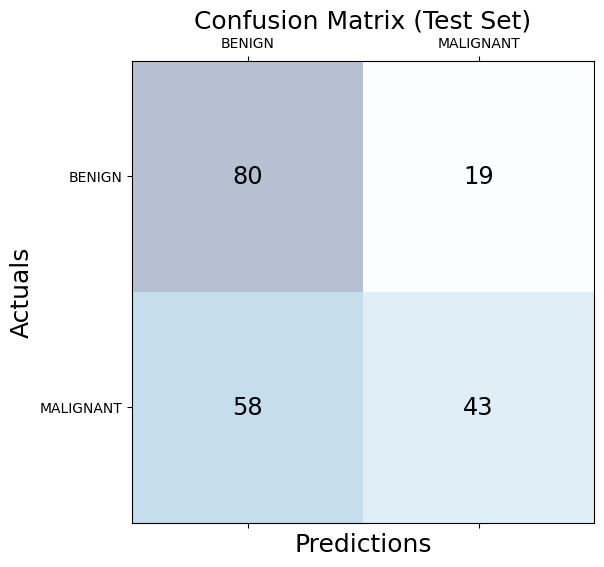

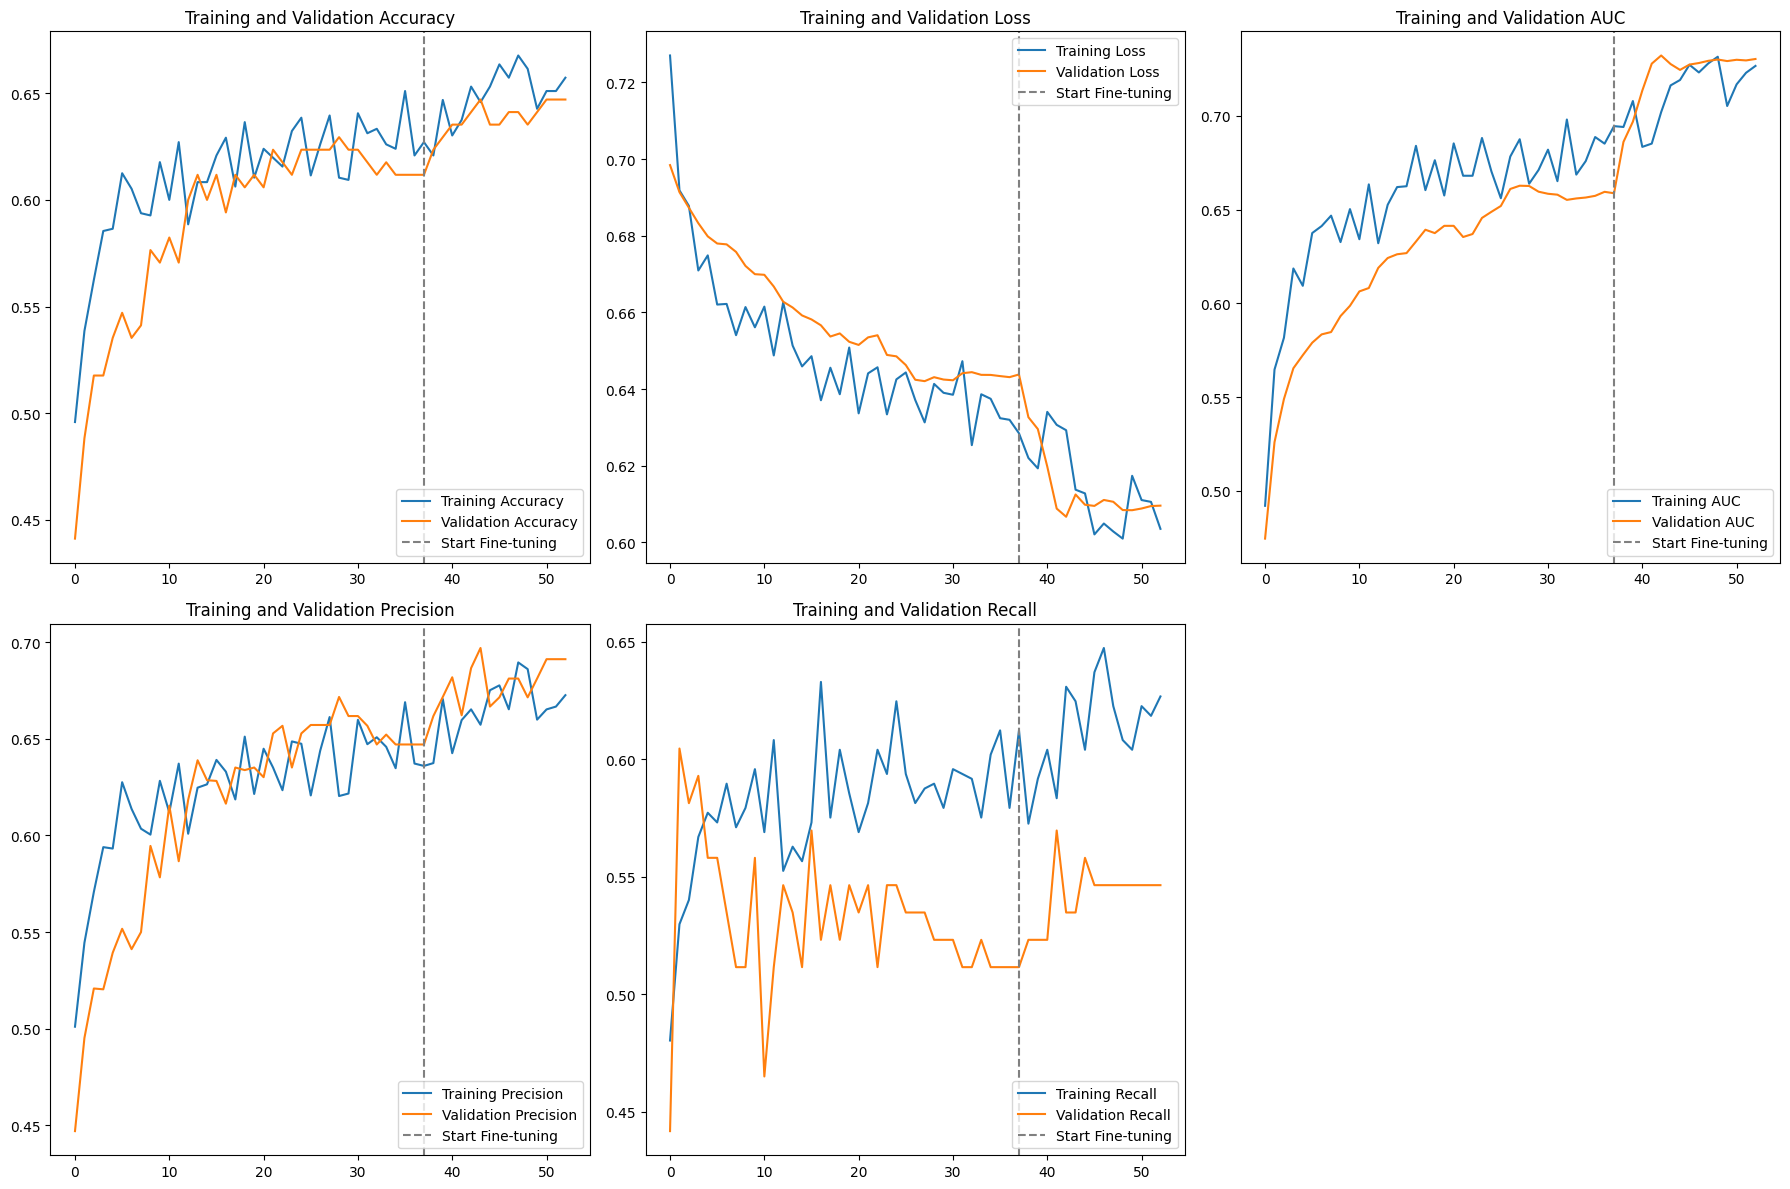


--- End of Script ---


In [10]:
# --- 5. Model Evaluation ---
print("\nPhase 5: Evaluating the Model on Test Set")
results = model.evaluate(test_dataset, verbose=1)
print("\nTest Set Evaluation Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

y_pred_proba = model.predict(test_dataset)
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()
y_true_test = []
for _, labels_batch in test_dataset: # Extract true labels from the tf.data.Dataset
    y_true_test.extend(labels_batch.numpy())
y_true_test = np.array(y_true_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_true_test, y_pred_classes, target_names=target_names))

cm = confusion_matrix(y_true_test, y_pred_classes)
print("\nConfusion Matrix (Test Set):")
print(cm)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (Test Set)', fontsize=18)
ax.set_xticks(range(len(target_names)))
ax.set_yticks(range(len(target_names)))
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.show()


# Plot Training History (combined)
acc = history_head.history['accuracy'] + history_fine_tune.history.get('accuracy', [])
val_acc = history_head.history['val_accuracy'] + history_fine_tune.history.get('val_accuracy', [])
loss_hist = history_head.history['loss'] + history_fine_tune.history.get('loss', [])
val_loss_hist = history_head.history['val_loss'] + history_fine_tune.history.get('val_loss', [])
auc = history_head.history['auc'] + history_fine_tune.history.get('auc', [])
val_auc = history_head.history['val_auc'] + history_fine_tune.history.get('val_auc', [])

epochs_range_head = range(len(history_head.history['accuracy']))
epochs_range_total = range(len(acc))


plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.plot(epochs_range_total, acc, label='Training Accuracy')
plt.plot(epochs_range_total, val_acc, label='Validation Accuracy')
plt.axvline(x=epochs_range_head[-1], color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 3, 2)
plt.plot(epochs_range_total, loss_hist, label='Training Loss')
plt.plot(epochs_range_total, val_loss_hist, label='Validation Loss')
plt.axvline(x=epochs_range_head[-1], color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 3, 3)
plt.plot(epochs_range_total, auc, label='Training AUC')
plt.plot(epochs_range_total, val_auc, label='Validation AUC')
plt.axvline(x=epochs_range_head[-1], color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

# Add precision and recall plots if desired
precision = history_head.history.get('precision', []) + history_fine_tune.history.get('precision', [])
val_precision = history_head.history.get('val_precision', []) + history_fine_tune.history.get('val_precision', [])
recall = history_head.history.get('recall', []) + history_fine_tune.history.get('recall', [])
val_recall = history_head.history.get('val_recall', []) + history_fine_tune.history.get('val_recall', [])

if precision: # Check if precision was recorded
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range_total, precision, label='Training Precision')
    plt.plot(epochs_range_total, val_precision, label='Validation Precision')
    plt.axvline(x=epochs_range_head[-1], color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')

if recall: # Check if recall was recorded
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range_total, recall, label='Training Recall')
    plt.plot(epochs_range_total, val_recall, label='Validation Recall')
    plt.axvline(x=epochs_range_head[-1], color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Recall')

plt.tight_layout()
plt.show()

print("\n--- End of Script ---")